In [1]:
library(Seurat)
library(Signac)
library(magrittr)
library(genomation)
library(GenomicRanges)
library(Matrix)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: grid

Warning message:
“replacing previous import ‘Biostrings::pattern’ by ‘grid::pattern’ when loading ‘genomation’”
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDupl

Specify file path

In [2]:
dir.scE2G_res = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/software/scE2G_pipeline/240617/sc-E2G/test/results/PBMC/"
path.obj.seurat = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/3.annotate_cell_type/obj.seurat.qc.56.rds"
dir.output = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/PBMC/1.prepare_data/3.1.merge_peaks.241022/"

In [3]:
dir.create(dir.output,recursive = T)

Import seurat object

In [4]:
obj.seurat = readRDS(path.obj.seurat)

In [6]:
table(obj.seurat$cell_type)


   15    17    18    19    20     B    DC  Mono    NK     T 
   94    58    26    25    23  1109   302  4953   774 11045 

In [7]:
table(obj.seurat$cell_type2)


      B      DC    Mono      NK       T Unknown 
   1109     302    4953     774   11045     226 

In [8]:
table(obj.seurat$cell_type3)


        01_HSC 02_Early.Eryth    05_CMP.LMPP         07_GMP         09_pDC 
            15              6              3             51             93 
        10_cDC 11_CD14.Mono.1 12_CD14.Mono.2   13_CD16.Mono         14_Unk 
           333            461           2713            593           1224 
      16_Pre.B           17_B      18_Plasma       19_CD8.N      20_CD4.N1 
            27            882             48            146            773 
      22_CD4.M      24_CD8.CM          25_NK         26_Unk 
          8006           2129            757            149 

Import E-G pairs for each cluster

In [9]:
list.pairs.E2G = list()
for (cell_type.tmp in c("B","DC","Mono","NK","T")){
    list.pairs.E2G[[cell_type.tmp]] = readGeneric(paste(dir.scE2G_res,
                                                        "/",
                                                        cell_type.tmp,
                                                        ".multiome_7features/Kendall/Pairs.tsv.gz",sep = ""),
                                                  header = T,
                                                  keep.all.metadata = T)


}

In [10]:
list.ABC.1M = list()
for (cell_type.tmp in c("B","DC","Mono","NK","T")){
    bed.tmp = readGeneric(paste(dir.scE2G_res,
                                "/",
                                cell_type.tmp,
                                ".multiome_7features/Predictions/EnhancerPredictionsAllPutative.tsv.gz",
                                sep = ""),
                          header = T,
                          keep.all.metadata = T)
    list.ABC.1M[[cell_type.tmp]] = bed.tmp[bed.tmp$distance < 10^6]
    rm(bed.tmp)
}

Check peak width

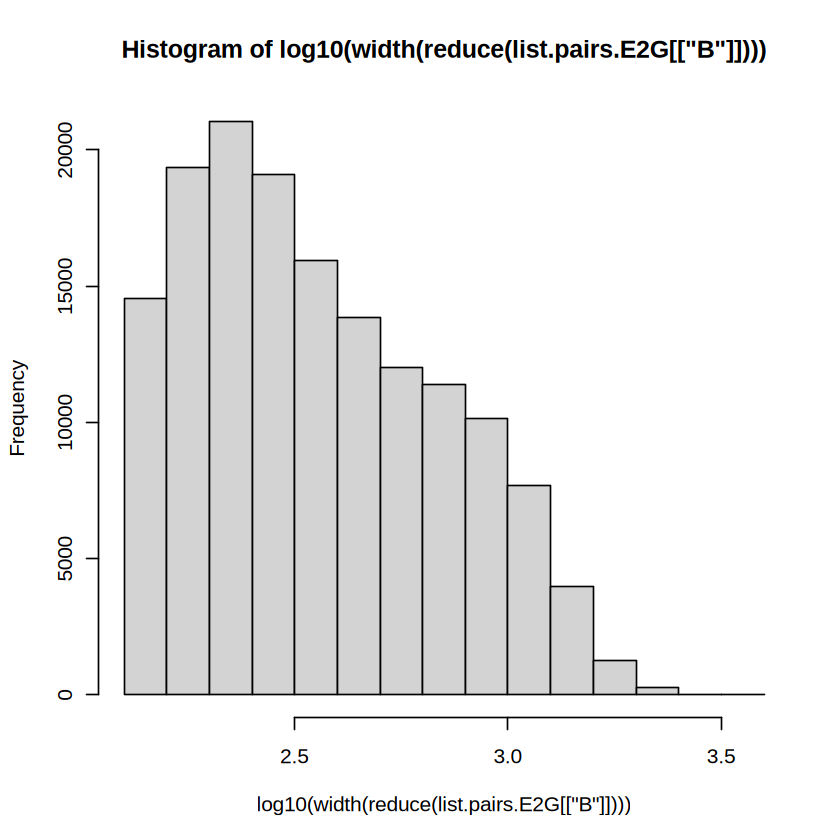

In [11]:
hist(log10(width(reduce(list.pairs.E2G[["B"]]))))

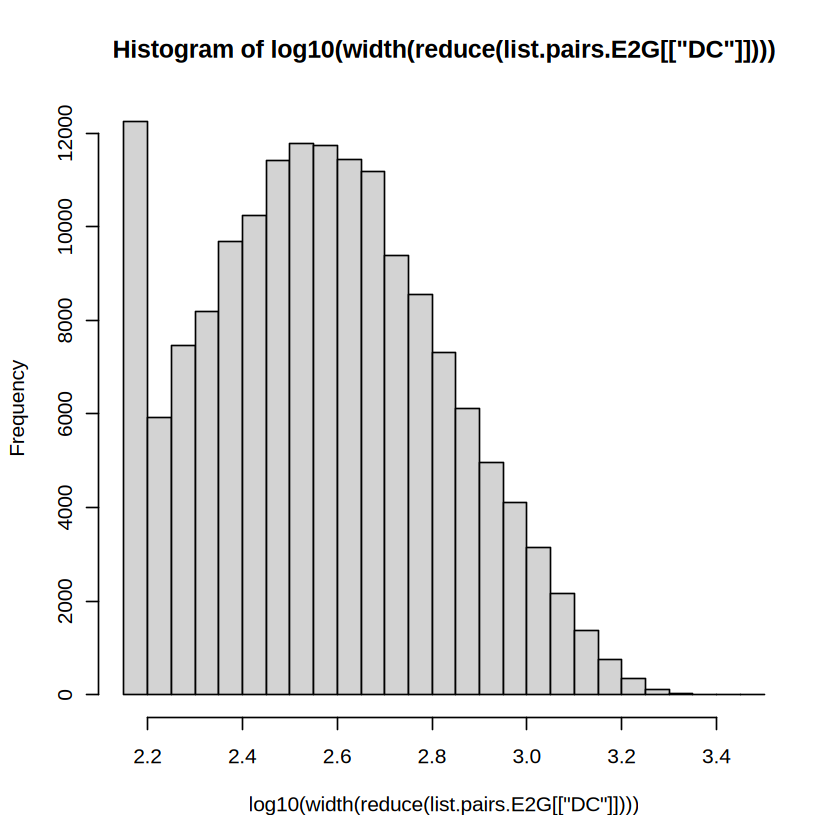

In [12]:
hist(log10(width(reduce(list.pairs.E2G[["DC"]]))))

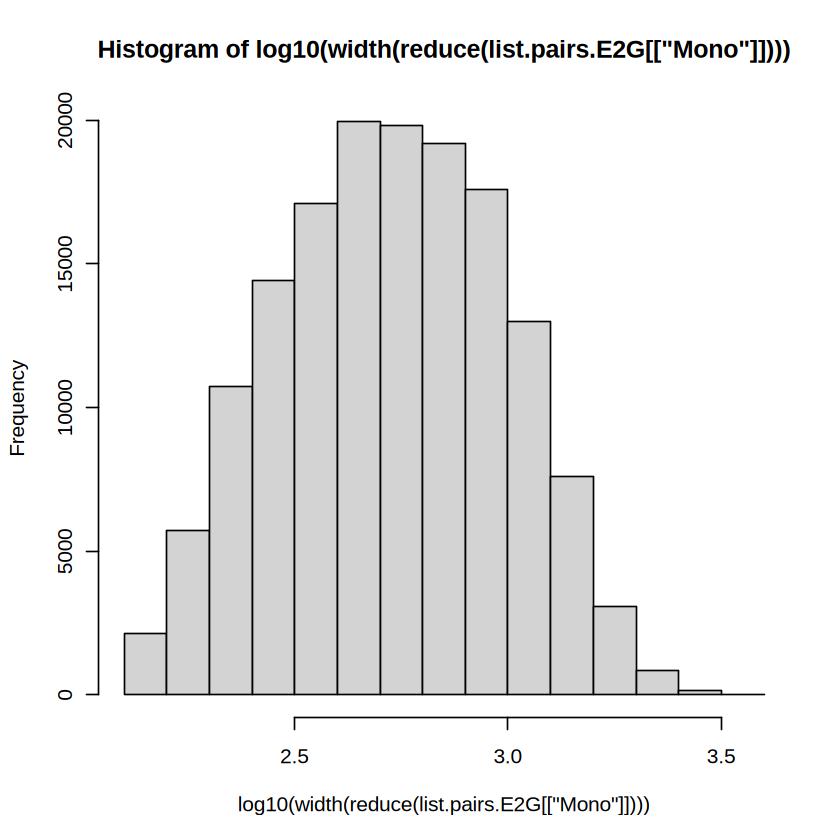

In [13]:
hist(log10(width(reduce(list.pairs.E2G[["Mono"]]))))

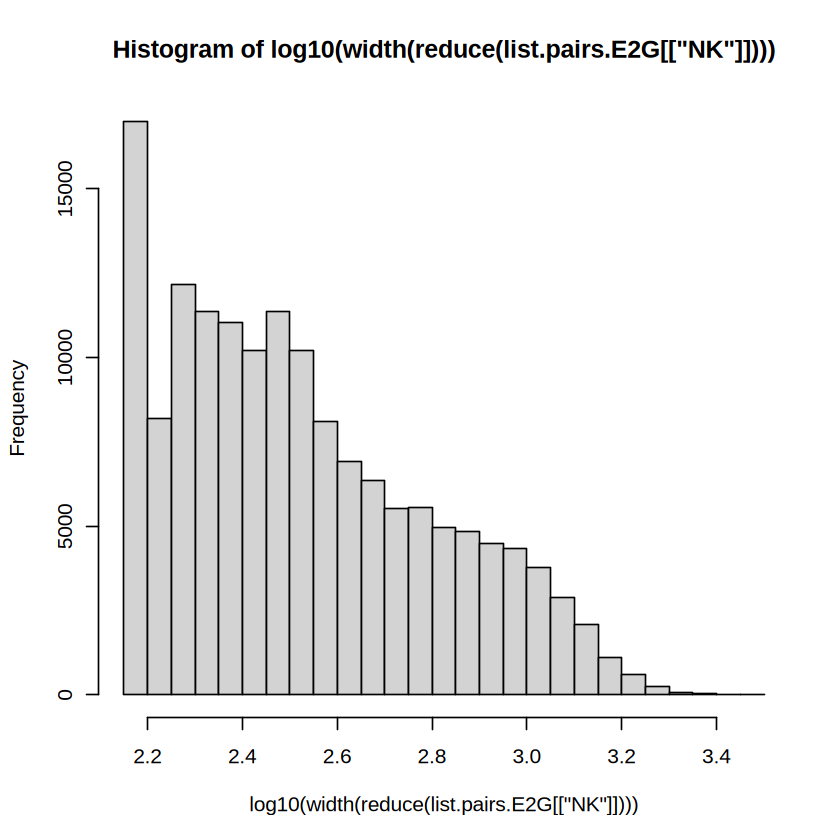

In [14]:
hist(log10(width(reduce(list.pairs.E2G[["NK"]]))))

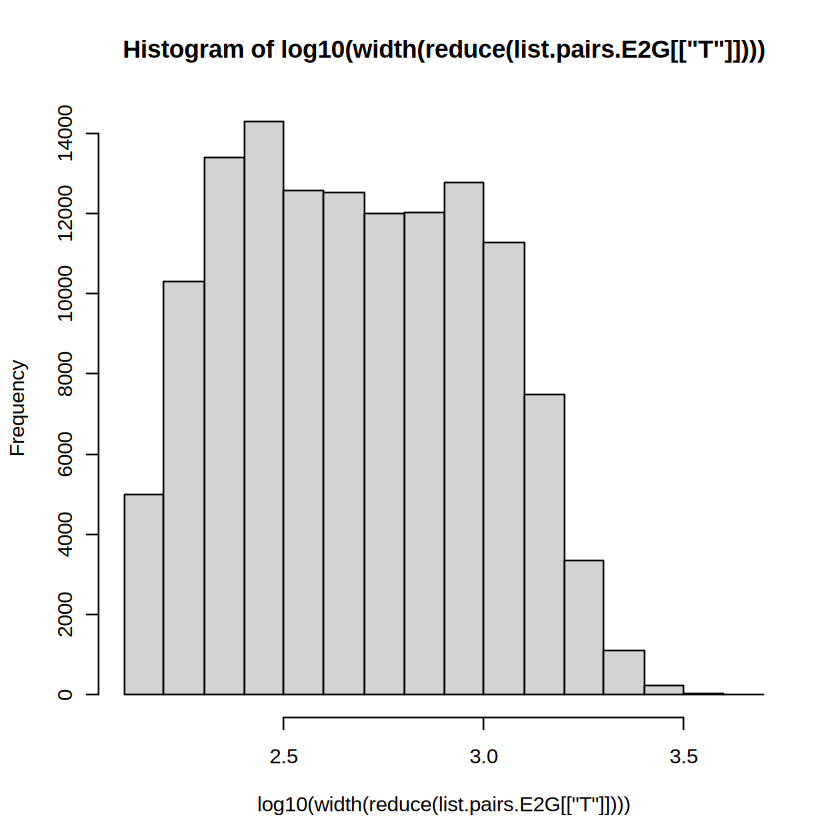

In [15]:
hist(log10(width(reduce(list.pairs.E2G[["T"]]))))

Merge peaks

In [16]:
bed.peaks = reduce(unlist(as(list.pairs.E2G, "GRangesList")))
bed.peaks

GRanges object with 305670 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1         10057-10601      *
       [2]     chr1       180665-181882      *
       [3]     chr1       191255-191955      *
       [4]     chr1       267886-268118      *
       [5]     chr1       271197-271524      *
       ...      ...                 ...    ...
  [305666]     chrX 156001461-156001911      *
  [305667]     chrX 156002551-156002801      *
  [305668]     chrX 156029380-156029530      *
  [305669]     chrX 156029605-156030380      *
  [305670]     chrX 156030498-156030791      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

Make E-G pairs

In [17]:
pair.ABC.1M = unlist(as(list.ABC.1M, "GRangesList"))

In [18]:
overlaps.res = findOverlaps(bed.peaks,
                            pair.ABC.1M)

In [19]:
pairs.peak_gene = bed.peaks[overlaps.res@from]
mcols(pairs.peak_gene)[,"TargetGene"] = mcols(pair.ABC.1M)[overlaps.res@to,"TargetGene"]
mcols(pairs.peak_gene)[,"PeakName"] = 
  paste(seqnames(pairs.peak_gene),
        start(pairs.peak_gene),
        end(pairs.peak_gene),
        sep = "-")

In [20]:
mcols(pairs.peak_gene)[,"PairName"] = 
  paste(mcols(pairs.peak_gene)[,"PeakName"],
        mcols(pairs.peak_gene)[,"TargetGene"],
        sep = "_")
pairs.peak_gene = pairs.peak_gene[order(mcols(pairs.peak_gene)[,"PairName"])]
pairs.peak_gene = pairs.peak_gene[!duplicated(mcols(pairs.peak_gene)[,"PairName"])]
pairs.peak_gene

GRanges object with 5800812 ranges and 3 metadata columns:
            seqnames              ranges strand |  TargetGene
               <Rle>           <IRanges>  <Rle> | <character>
        [1]     chr1 100028331-100029533      * |         AGL
        [2]     chr1 100028331-100029533      * |      CDC14A
        [3]     chr1 100028331-100029533      * |         DBT
        [4]     chr1 100028331-100029533      * |        DPH5
        [5]     chr1 100028331-100029533      * |       EXTL2
        ...      ...                 ...    ... .         ...
  [5800808]     chrX     9995651-9996434      * |        WWC3
  [5800809]     chrX     9997538-9997892      * |       CLCN4
  [5800810]     chrX     9997538-9997892      * |      GPR143
  [5800811]     chrX     9997538-9997892      * |       TBL1X
  [5800812]     chrX     9997538-9997892      * |        WWC3
                          PeakName               PairName
                       <character>            <character>
        [1] chr1-10

Generate peak x cell matrix

In [21]:
bed.peaks.matrix = reduce(pairs.peak_gene)
bed.peaks.matrix

GRanges object with 303411 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1         10057-10601      *
       [2]     chr1       180665-181882      *
       [3]     chr1       191255-191955      *
       [4]     chr1       267886-268118      *
       [5]     chr1       271197-271524      *
       ...      ...                 ...    ...
  [303407]     chrX 156001461-156001911      *
  [303408]     chrX 156002551-156002801      *
  [303409]     chrX 156029380-156029530      *
  [303410]     chrX 156029605-156030380      *
  [303411]     chrX 156030498-156030791      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

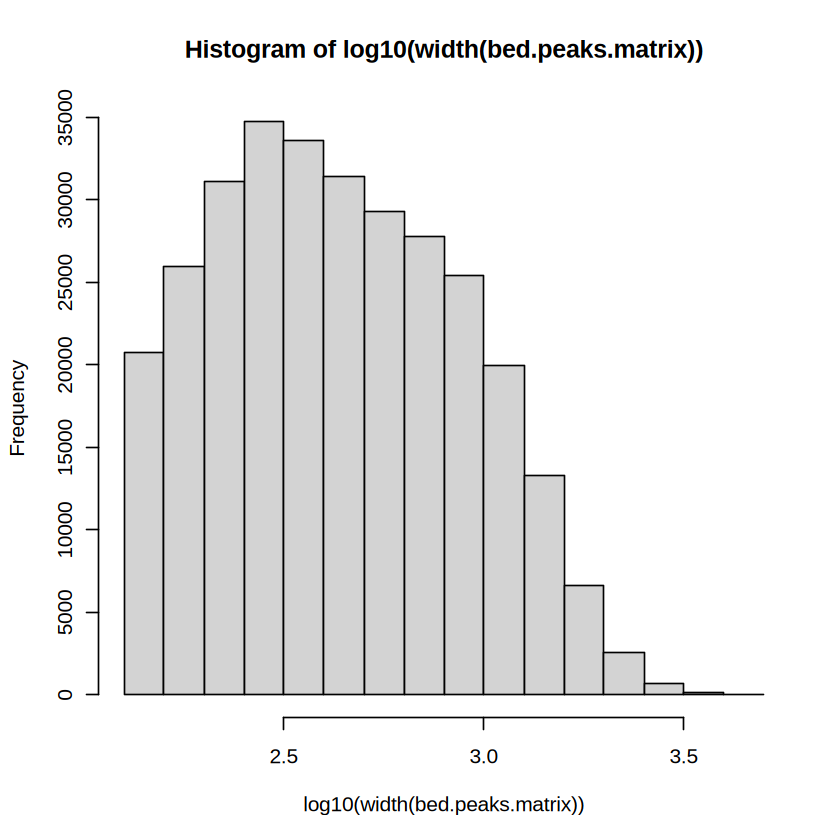

In [22]:
hist(log10(width(bed.peaks.matrix)))

Generate ATAC matrix

In [23]:
future::plan("multicore", workers = 32)
atac.matrix <- FeatureMatrix(
  fragments = obj.seurat@assays$ATAC_empty@fragments,
  features = bed.peaks.matrix,
  cells = colnames(obj.seurat@assays$RNA$counts)
)
future::plan("sequential")

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [24]:
obj.seurat[["ATAC"]] <- CreateChromatinAssay(
  counts = atac.matrix,
  fragments = obj.seurat@assays$ATAC_empty@fragments
)
DefaultAssay(obj.seurat) <- "ATAC"

In [25]:
obj.seurat <- obj.seurat %>%
  RunTFIDF() %>%
  FindTopFeatures(min.cutoff = 'q0') %>%
  RunSVD() %>%
  RunUMAP(reduction = 'lsi', dims = 2:30)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:03:06 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

10:03:06 Read 18409 rows and found 29 numeric columns

10:03:06 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

10:03:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*


In [26]:
dir.create("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.1.merge_peaks.241022/",recursive = T)

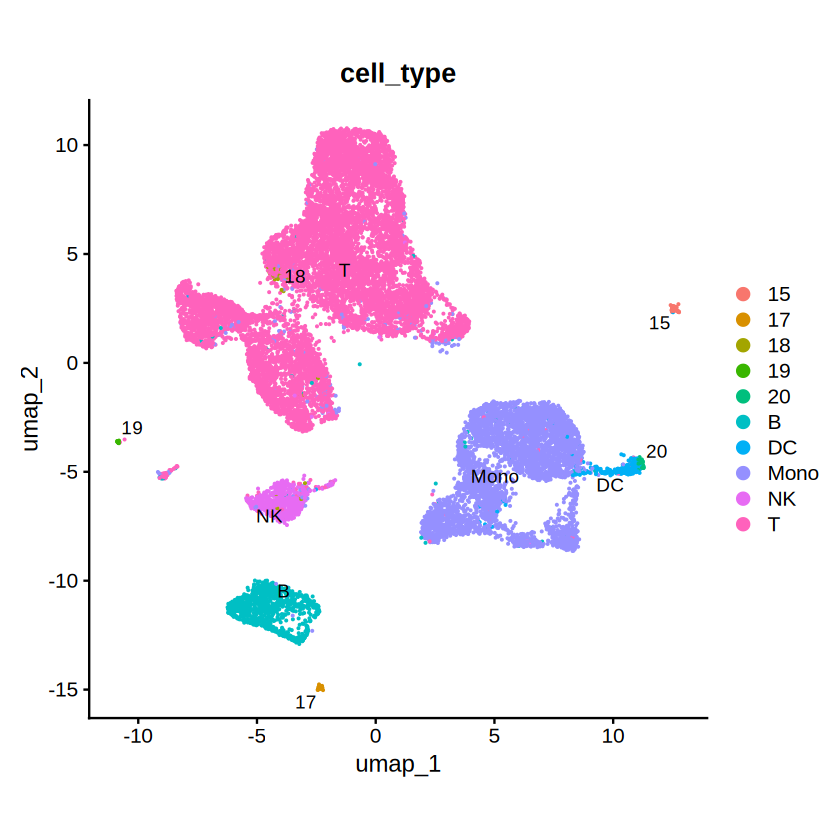

In [27]:
p = DimPlot(obj.seurat, 
        group.by = "cell_type",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.1.merge_peaks.241022/UMAP.ATAC.cell_type.pdf", 
       plot = p, 
       width = 10, height = 8)

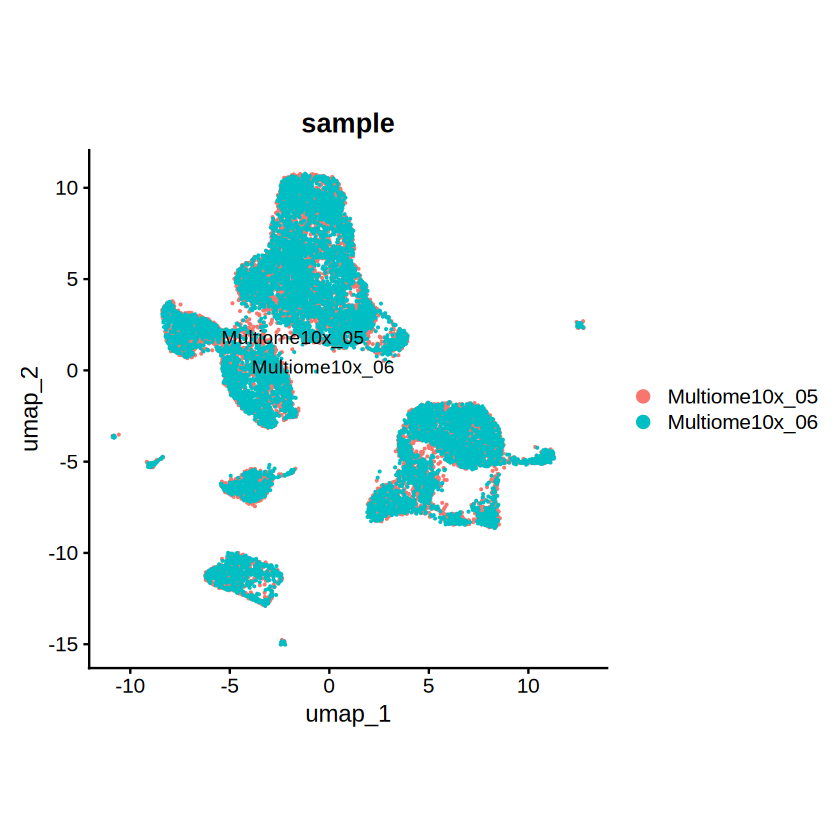

In [28]:
p = DimPlot(obj.seurat, 
        group.by = "sample",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/output/PBMC/1.prepare_data/3.1.merge_peaks.241022/UMAP.ATAC.sample.pdf", 
       plot = p, 
       width = 10, height = 8)

Save data

In [29]:
saveRDS(obj.seurat,
        paste(dir.output, "obj.seurat.rds", sep = "/"))

In [30]:
saveRDS(obj.seurat@assays$RNA$counts,
        paste(dir.output, "matrix.rna.rds", sep = "/"))

In [31]:
saveRDS(obj.seurat@assays$ATAC$counts,
        paste(dir.output, "matrix.atac.rds", sep = "/"))

In [32]:
saveRDS(pairs.peak_gene,
        paste(dir.output, "pairs.rds", sep = "/"))

In [33]:
data.table::fwrite(as.data.frame(as.matrix(obj.seurat@assays$ATAC$counts)),
                   paste(dir.output, "matrix.atac.csv.gz", sep = "/"),
                   row.names = T)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 41.6 GiB”


In [34]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.10 (Ootpa)

Matrix products: default
BLAS/LAPACK: /maps/projects/ralab/people/lpm537/software/anaconda3/envs/Notebook_E2G_240505/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Copenhagen
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggplot2_3.5.1        Matrix_1.6-5         GenomicRanges_1.54.1
 [4] GenomeInfoDb_1.38.1  IRanges_2.36.0       S4Vectors_0.40.2   